# 05__validation

in this notebook, i compare our screen results to individual validations performed on 22 sgRNAs.

figures in this notebook:
- Fig 4A: scatter plot showing the comparison between screen results and individual validation results
- Fig 4B: RT-qPCR results for a subset of mRNAs
- Fig 4C: RT-qPCR results for a subset of lncRNAs

tables in this notebook:
- Table S4: validation results + screen results for these validated sgRNAs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from os import walk
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
data_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S2.sgRNA_results.txt"

In [4]:
crisphie_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"

In [5]:
validation_data_f = "../../../data/02__screen/03__validation_data/validation_data.xlsx"

In [6]:
qpcr_dir = "../../../data/02__screen/03__validation_data/rt_qpcr_data"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
#data["sgRNA_rank"] = data["sgRNA_rank"].astype(str)
data.head()

sgRNA control_status    gene_name              gene_id  \
0  TTGCAAGTGTCTTTAAACTA   experimental  RP4-714D9.2  ENSG00000241073.1_2   
1  ATTGCAAGTGTCTTTAAACT   experimental  RP4-714D9.2  ENSG00000241073.1_2   
2  AGCCAGTATCTTGAAACTAT   experimental  RP4-714D9.2  ENSG00000241073.1_2   
3  TGCCAATAGTTTCAAGATAC   experimental  RP4-714D9.2  ENSG00000241073.1_2   
4  ACAGTAGTGTATCTAAATGG   experimental  RP4-714D9.2  ENSG00000241073.1_2   

   transcript_name        transcript_id                    tss_id  \
0  RP4-714D9.2-001  ENST00000432294.1_1  NC_000001.11:-:100084320   
1  RP4-714D9.2-001  ENST00000432294.1_1  NC_000001.11:-:100084320   
2  RP4-714D9.2-001  ENST00000432294.1_1  NC_000001.11:-:100084320   
3  RP4-714D9.2-001  ENST00000432294.1_1  NC_000001.11:-:100084320   
4  RP4-714D9.2-001  ENST00000432294.1_1  NC_000001.11:-:100084320   

  tss_chr_hg38 tss_start_hg38 tss_strand_hg38  ... Diff_Rep2__counts  \
0         chr1      100084320               -  ...               769   
1         chr1      100084320               -  ...               482   
2         chr1      100084320               -  ...               700   
3         chr1      100084320               -  ...               382   
4         chr1      100084320               -  ...               679   

   DayZero_Rep1__cp,  DayZero_Rep2__cpm  Undiff_Rep1__cpm  Undiff_Rep2__cpm  \
0           6.374260           9.515495          5.975173          7.449968   
1           3.209212           4.041303          0.006844          3.192843   
2           5.380582           6.378442          0.006844          7.669919   
3           3.098803           3.665691          3.538562          4.150696   
4           8.346894           8.200854          0.006844          4.902788   

   Diff_Rep1__cpm  Diff_Rep2__cpm    sgRNA_status  sgRNA_l2fc  sgRNA_l2fcSE  
0        2.683950        7.813446  filter not met    0.510908      0.869775  
1        5.414577        4.901161  filter not met   -1.531524      2.792996  
2        4.518371        7.113280  filter not met   -0.439532      2.789519  
3        5.349229        3.886428  filter not met   -0.108926      0.682448  
4       10.567761        6.900186  filter not met   -1.671807      2.658805  

[5 rows x 26 columns]

In [8]:
val_data = pd.read_excel(validation_data_f)
print(len(val_data))
val_data.head()

24


gene_name  guide_num        guide_sequence  guide_undiff  scram_undiff  \
0  ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG         24.49          1.53   
1  ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG         38.75          1.53   
2       DIGIT          8  AAATCAGGCGGTGAGTACGT         23.99          1.82   
3       EOMES         10  CGCGGGCTAGTGGGTGGATG          9.68          1.65   
4       EOMES          1  TTTGCAAAGCATGCAGTTAG         39.81          1.65   

   guide_diff  scram_diff  rtqpcr_kd_level  date_facs  date_rtqpcr  
0       11.74       62.30             0.55     190906       190906  
1        6.24       62.30             0.51     190906       190906  
2       23.63       59.22             0.10     190816       190829  
3       45.46       61.37             0.50     190508       190726  
4       22.27       61.37             0.21     190508       190709

In [9]:
crisphie = pd.read_table(crisphie_f, sep="\t")
print(len(crisphie))
crisphie.head()

9771


group_id                       transcript_name  \
0  NC_000008.11:+:54457934                             SOX17-001   
1  NC_000003.12:-:27722707                             EOMES-004   
2  NC_000003.12:-:27722322                             EOMES-001   
3  NC_000023.11:-:11111137  [RP11-120D5.1-004, RP11-120D5.1-005]   
4  NC_000003.12:-:38454682                        ACVR2B-AS1-001   

    ctrl_status transcript_biotype_status  CRISPhieRmix_FDR  effect_size  \
0       control            protein_coding      0.000000e+00     7.864574   
1       control            protein_coding      0.000000e+00     5.932002   
2       control            protein_coding      0.000000e+00     5.397301   
3  experimental          promoter_overlap      0.000000e+00     4.211808   
4  experimental          promoter_overlap      1.265654e-15     3.110333   

  hit_status  n_sgRNA  
0        hit        7  
1        hit        6  
2        hit        6  
3        hit        7  
4        hit       10

In [10]:
files = []
for (dirpath, dirnames, filenames) in walk(qpcr_dir):
    files.extend(filenames)
    break
print(len(files))
files

24


['acvr2b-as1__sgrna__6.txt',
 'acvr2b-as1__sgrna__8.txt',
 'digit__sgrna__8.txt',
 'eomes__sgrna__1.txt',
 'eomes__sgrna__10.txt',
 'foxa2__sgrna__1.txt',
 'foxa2__sgrna__5.txt',
 'gata6__sgrna__1.txt',
 'gata6__sgrna__5.txt',
 'kb-1440d3.14__sgrna__9.txt',
 'linc00479__sgrna__3.txt',
 'pvt1__sgrna__1.txt',
 'pvt1__sgrna__2.txt',
 'pvt1__sgrna__6.txt',
 'pvt1__sgrna__9.txt',
 'rp11-120d5.1__sgrna__1.txt',
 'rp11-120d5.1__sgrna__2.txt',
 'rp11-222k16.2__sgrna__3.txt',
 'rp11-222k16.2__sgrna__9.txt',
 'rp11-23f23.2__sgrna__6.txt',
 'rp3-508i15.9__sgrna__1.txt',
 'rp3-508i15.9__sgrna__2.txt',
 'sox17__sgrna__1.txt',
 'sox17__sgrna__4.txt']

## 2. merge validation data w/ screen data

In [11]:
data_sub = data[["sgRNA", "sgRNA_l2fc", "tss_id"]]

In [12]:
val_data = val_data.merge(data_sub, left_on="guide_sequence", right_on="sgRNA", how="left")

In [13]:
val_data = val_data.merge(crisphie[["group_id", "transcript_biotype_status", "hit_status"]], 
                          left_on="tss_id", right_on="group_id", how="left")
val_data.drop(["sgRNA", "group_id"], axis=1, inplace=True)
val_data

gene_name  guide_num        guide_sequence  guide_undiff  \
0      ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG         24.49   
1      ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG         38.75   
2           DIGIT          8  AAATCAGGCGGTGAGTACGT         23.99   
3           EOMES         10  CGCGGGCTAGTGGGTGGATG          9.68   
4           EOMES          1  TTTGCAAAGCATGCAGTTAG         39.81   
5           FOXA2          1  TGCATAGTAGCTGCTCCAGT          5.41   
6           FOXA2          5  CAGGCCAGCGCCCCGCGGTA          3.41   
7           GATA6          1  CAGGCGCGGAGAGAAGCCGA         28.63   
8           GATA6          5  ACCCACAGCCTGGCACCCTT         50.85   
9    KB-1440D3.14          9  CCTCAAACTACCCCTCCCCC         33.19   
10      LINC00479          3  TTTACGGCACCTTGGTGCGA          1.62   
11           PVT1          1  GTCGTCGCCCCTCCTCGTCC          2.51   
12           PVT1          9  CCCGAGCCCGCCCGGCCCGC          6.00   
13           PVT1          2  CGGCCGAGCACATGGGCCCG          5.89   
14           PVT1          6  TCAATCCTCAGAACCCTGAG          1.12   
15   RP11-120D5.1          1  GGGAAGGTTGTCTGCTCCAG         49.19   
16   RP11-120D5.1          2  ATAGTAGAGCTCTTCACTCT         26.54   
17  RP11-222K16.2          3  TGTCTTGAAAAGAATGTCGG          1.49   
18  RP11-222K16.2          9  GAGCTGTCGAAATCTCCGCG          1.27   
19   RP11-23F23.2          6  CTCGGTTCAATGAGGGCCCC          1.78   
20   RP3-508I15.9          2  CCGACGCCCGGATAAGGCCA          5.11   
21   RP3-508I15.9          1  GAAGCCCCGACGCCCGGATA          2.04   
22          SOX17          4  GCTGTAGACCAGACCGCGAC         82.26   
23          SOX17          1  TCTGGTCTACAGCGTACCCA         81.23   

    scram_undiff  guide_diff  scram_diff  rtqpcr_kd_level  date_facs  \
0           1.53       11.74       62.30             0.55     190906   
1           1.53        6.24       62.30             0.51     190906   
2           1.82       23.63       59.22             0.10     190816   
3           1.65       45.46       61.37             0.50     190508   
4           1.65       22.27       61.37             0.21     190508   
5           1.89        1.06       64.77             0.10     180507   
6           1.65        8.41       61.37             0.07     190508   
7           1.89       21.58       64.77             0.54     180507   
8           1.65       19.22       61.37             0.37     190508   
9           1.29       12.59       60.75             0.60     190822   
10          1.29       67.17       60.75             0.55     190822   
11          1.29       53.02       60.75             0.04     190822   
12          1.29       36.63       60.75             0.03     190822   
13          1.82       33.69       59.22             0.26     190816   
14          1.29       56.43       60.75             0.05     190822   
15          1.53        3.88       62.30             0.04     190906   
16          1.53        3.90       62.30             0.17     190906   
17          1.48       38.45       60.59             0.31     190325   
18          1.48       24.01       60.59             0.19     190325   
19          1.29       45.74       60.75             0.11     190822   
20          1.54       59.74       55.59             0.42     190903   
21          1.29       46.33       60.75             0.40     190822   
22          1.65        8.55       61.37             0.10     190508   
23          1.48        0.06       60.59             0.07     190325   

    date_rtqpcr  sgRNA_l2fc                    tss_id  \
0        190906    2.358497   NC_000003.12:-:38454682   
1        190906    3.129730   NC_000003.12:-:38454682   
2        190829    2.676944    NC_000014.9:+:94770641   
3        190726    5.932002   NC_000003.12:-:27722707   
4        190709    7.778685   NC_000003.12:-:27722322   
5        190726         NaN                       NaN   
6        190709    3.362388   NC_000020.11:-:22584571   
7        190726         NaN                       

## 3. calculate validation data "enrichment" (guide enrichment normalized by scrambled enrichment)

In [14]:
val_data["guide_undiff_enrich"] = val_data["guide_undiff"]/val_data["guide_diff"]
val_data["scram_undiff_enrich"] = val_data["scram_undiff"]/val_data["scram_diff"]
val_data["val_score"] = np.log2(val_data["guide_undiff_enrich"]/val_data["scram_undiff_enrich"])
val_data.sort_values(by="sgRNA_l2fc", ascending=False)

gene_name  guide_num        guide_sequence  guide_undiff  \
22          SOX17          4  GCTGTAGACCAGACCGCGAC         82.26   
4           EOMES          1  TTTGCAAAGCATGCAGTTAG         39.81   
3           EOMES         10  CGCGGGCTAGTGGGTGGATG          9.68   
9    KB-1440D3.14          9  CCTCAAACTACCCCTCCCCC         33.19   
20   RP3-508I15.9          2  CCGACGCCCGGATAAGGCCA          5.11   
16   RP11-120D5.1          2  ATAGTAGAGCTCTTCACTCT         26.54   
15   RP11-120D5.1          1  GGGAAGGTTGTCTGCTCCAG         49.19   
8           GATA6          5  ACCCACAGCCTGGCACCCTT         50.85   
6           FOXA2          5  CAGGCCAGCGCCCCGCGGTA          3.41   
18  RP11-222K16.2          9  GAGCTGTCGAAATCTCCGCG          1.27   
1      ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG         38.75   
2           DIGIT          8  AAATCAGGCGGTGAGTACGT         23.99   
23          SOX17          1  TCTGGTCTACAGCGTACCCA         81.23   
21   RP3-508I15.9          1  GAAGCCCCGACGCCCGGATA          2.04   
0      ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG         24.49   
14           PVT1          6  TCAATCCTCAGAACCCTGAG          1.12   
13           PVT1          2  CGGCCGAGCACATGGGCCCG          5.89   
19   RP11-23F23.2          6  CTCGGTTCAATGAGGGCCCC          1.78   
10      LINC00479          3  TTTACGGCACCTTGGTGCGA          1.62   
12           PVT1          9  CCCGAGCCCGCCCGGCCCGC          6.00   
11           PVT1          1  GTCGTCGCCCCTCCTCGTCC          2.51   
17  RP11-222K16.2          3  TGTCTTGAAAAGAATGTCGG          1.49   
5           FOXA2          1  TGCATAGTAGCTGCTCCAGT          5.41   
7           GATA6          1  CAGGCGCGGAGAGAAGCCGA         28.63   

    scram_undiff  guide_diff  scram_diff  rtqpcr_kd_level  date_facs  \
22          1.65        8.55       61.37             0.10     190508   
4           1.65       22.27       61.37             0.21     190508   
3           1.65       45.46       61.37             0.50     190508   
9           1.29       12.59       60.75             0.60     190822   
20          1.54       59.74       55.59             0.42     190903   
16          1.53        3.90       62.30             0.17     190906   
15          1.53        3.88       62.30             0.04     190906   
8           1.65       19.22       61.37             0.37     190508   
6           1.65        8.41       61.37             0.07     190508   
18          1.48       24.01       60.59             0.19     190325   
1           1.53        6.24       62.30             0.51     190906   
2           1.82       23.63       59.22             0.10     190816   
23          1.48        0.06       60.59             0.07     190325   
21          1.29       46.33       60.75             0.40     190822   
0           1.53       11.74       62.30             0.55     190906   
14          1.29       56.43       60.75             0.05     190822   
13          1.82       33.69       59.22             0.26     190816   
19          1.29       45.74       60.75             0.11     190822   
10          1.29       67.17       60.75             0.55     190822   
12          1.29       36.63       60.75             0.03     190822   
11          1.29       53.02       60.75             0.04     190822   
17          1.48       38.45       60.59             0.31     190325   
5           1.89        1.06       64.77             0.10     180507   
7           1.89       21.58       64.77             0.54     180507   

    date_rtqpcr  sgRNA_l2fc                    tss_id  \
22       190709    7.864574   NC_000008.11:+:54457934   
4        190709    7.778685   NC_000003.12:-:27722322   
3        190726    5.932002   NC_000003.12:-:27722707   
9        190829    4.773058   NC_000022.11:+:21640844   
20       190906    4.477188   NC_000022.11:-:38681855   
16       190906    4.156723   NC_000023.11:-:11111137   
15       190906    4.046443   NC_000023.11:-:11111137   
8        190709    3.587999   NC_000018.10:+:22169

In [15]:
# remove the 2 sgRNAs that weren't in the screen
val_data = val_data[~pd.isnull(val_data["hit_status"])]
val_data

gene_name  guide_num        guide_sequence  guide_undiff  \
0      ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG         24.49   
1      ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG         38.75   
2           DIGIT          8  AAATCAGGCGGTGAGTACGT         23.99   
3           EOMES         10  CGCGGGCTAGTGGGTGGATG          9.68   
4           EOMES          1  TTTGCAAAGCATGCAGTTAG         39.81   
6           FOXA2          5  CAGGCCAGCGCCCCGCGGTA          3.41   
8           GATA6          5  ACCCACAGCCTGGCACCCTT         50.85   
9    KB-1440D3.14          9  CCTCAAACTACCCCTCCCCC         33.19   
10      LINC00479          3  TTTACGGCACCTTGGTGCGA          1.62   
11           PVT1          1  GTCGTCGCCCCTCCTCGTCC          2.51   
12           PVT1          9  CCCGAGCCCGCCCGGCCCGC          6.00   
13           PVT1          2  CGGCCGAGCACATGGGCCCG          5.89   
14           PVT1          6  TCAATCCTCAGAACCCTGAG          1.12   
15   RP11-120D5.1          1  GGGAAGGTTGTCTGCTCCAG         49.19   
16   RP11-120D5.1          2  ATAGTAGAGCTCTTCACTCT         26.54   
17  RP11-222K16.2          3  TGTCTTGAAAAGAATGTCGG          1.49   
18  RP11-222K16.2          9  GAGCTGTCGAAATCTCCGCG          1.27   
19   RP11-23F23.2          6  CTCGGTTCAATGAGGGCCCC          1.78   
20   RP3-508I15.9          2  CCGACGCCCGGATAAGGCCA          5.11   
21   RP3-508I15.9          1  GAAGCCCCGACGCCCGGATA          2.04   
22          SOX17          4  GCTGTAGACCAGACCGCGAC         82.26   
23          SOX17          1  TCTGGTCTACAGCGTACCCA         81.23   

    scram_undiff  guide_diff  scram_diff  rtqpcr_kd_level  date_facs  \
0           1.53       11.74       62.30             0.55     190906   
1           1.53        6.24       62.30             0.51     190906   
2           1.82       23.63       59.22             0.10     190816   
3           1.65       45.46       61.37             0.50     190508   
4           1.65       22.27       61.37             0.21     190508   
6           1.65        8.41       61.37             0.07     190508   
8           1.65       19.22       61.37             0.37     190508   
9           1.29       12.59       60.75             0.60     190822   
10          1.29       67.17       60.75             0.55     190822   
11          1.29       53.02       60.75             0.04     190822   
12          1.29       36.63       60.75             0.03     190822   
13          1.82       33.69       59.22             0.26     190816   
14          1.29       56.43       60.75             0.05     190822   
15          1.53        3.88       62.30             0.04     190906   
16          1.53        3.90       62.30             0.17     190906   
17          1.48       38.45       60.59             0.31     190325   
18          1.48       24.01       60.59             0.19     190325   
19          1.29       45.74       60.75             0.11     190822   
20          1.54       59.74       55.59             0.42     190903   
21          1.29       46.33       60.75             0.40     190822   
22          1.65        8.55       61.37             0.10     190508   
23          1.48        0.06       60.59             0.07     190325   

    date_rtqpcr  sgRNA_l2fc                    tss_id  \
0        190906    2.358497   NC_000003.12:-:38454682   
1        190906    3.129730   NC_000003.12:-:38454682   
2        190829    2.676944    NC_000014.9:+:94770641   
3        190726    5.932002   NC_000003.12:-:27722707   
4        190709    7.778685   NC_000003.12:-:27722322   
6        190709    3.362388   NC_000020.11:-:22584571   
8        190709    3.587999   NC_000018.10:+:22169434   
9        190829    4.773058   NC_000022.11:+:21640844   
10       190829    1.403102    NC_000021.9:-:41715746   
11       190906    0.431654  NC_000008.11:+:127794540   
12       190829    1.290649  NC_000008.11:+:127794540   
13       190829    1.813354  NC_000008.11:+:127794540   
14       190829    2.346079  NC_000008.11:+:1

## 4. plot correlation -- all validated sgRNAs

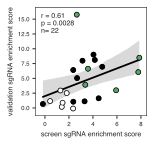

In [16]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=val_data, x="sgRNA_l2fc", y="val_score", color="black")

hits = val_data[val_data["hit_status"] == "hit"]
nonhits = val_data[val_data["hit_status"] == "no hit"]

pc_hits = hits[hits["transcript_biotype_status"] == "protein_coding"]
pc_nonhits = nonhits[nonhits["transcript_biotype_status"] == "protein_coding"]

lnc_hits = hits[hits["transcript_biotype_status"] != "protein_coding"]
lnc_nonhits = nonhits[nonhits["transcript_biotype_status"] != "protein_coding"]

ax.scatter(pc_hits["sgRNA_l2fc"], pc_hits["val_score"], color=sns.color_palette()[2], zorder=11,
           edgecolors="black", linewidth=0.5)
ax.scatter(pc_nonhits["sgRNA_l2fc"], pc_nonhits["val_score"], color="white", 
           edgecolors=sns.color_palette()[2], linewidth=0.5, zorder=11)

ax.scatter(lnc_hits["sgRNA_l2fc"], lnc_hits["val_score"], color="black", zorder=11)
ax.scatter(lnc_nonhits["sgRNA_l2fc"], lnc_nonhits["val_score"], color="white", 
           edgecolors="black", linewidth=0.5, zorder=11)

ax.set_xlabel("screen sgRNA enrichment score")
ax.set_ylabel("validation sgRNA enrichment score")

no_nan = val_data[~pd.isnull(val_data["sgRNA_l2fc"])]
r, p = stats.spearmanr(no_nan["sgRNA_l2fc"], no_nan["val_score"])
ax.text(0.05, 0.95, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 4), len(no_nan))), 
        ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

fig.savefig("Fig4A.pdf", dpi="figure", bbox_inches="tight")

In [17]:
val_data[val_data["gene_name"] == "RP11-222K16.2"][["guide_num", "guide_sequence", "sgRNA_l2fc", "val_score"]]

guide_num        guide_sequence  sgRNA_l2fc  val_score
17          3  TGTCTTGAAAAGAATGTCGG   -0.170594   0.665811
18          9  GAGCTGTCGAAATCTCCGCG    3.303674   1.114676

## 5. load RT-qPCR data

In [18]:
def row_type(row):
    if "scrm" in row["variable"]:
        return "scramble"
    else:
        return "sgRNA"

In [19]:
qpcr_dict = {}

for f in files:
    n = f.split("__")[0]
    sgrna = f.split("__")[2].split(".")[0]
    df = pd.read_table("%s/%s" % (qpcr_dir, f))
    df.columns = ["gene", "scrm_val", "scrm_yerr1", "scrm_yerr2", "sgrna_val", "sgrna_yerr1", "sgrna_yerr2"]
    melt = pd.melt(df, id_vars=["gene"])
    melt["type"] = melt.apply(row_type, axis=1)
    qpcr_dict["%s__%s" % (n.upper(), sgrna)] = melt

In [20]:
qpcr_dict["SOX17__1"]

gene     variable     value      type
0  SOX17     scrm_val  1.000000  scramble
1  SOX17   scrm_yerr1  0.030124  scramble
2  SOX17   scrm_yerr2  0.030124  scramble
3  SOX17    sgrna_val  0.071298     sgRNA
4  SOX17  sgrna_yerr1  0.006562     sgRNA
5  SOX17  sgrna_yerr2  0.006562     sgRNA

## 6. make RT-qPCR plots
for SOX17, EOMES, RP11-120D5.1, RP11-222K16.2 (figure 4)

In [21]:
genes = ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2"]
plot_df = pd.DataFrame()

for key in qpcr_dict:
    gene = key.split("__")[0]
    if gene in genes:
        df = qpcr_dict[key]
        df["info"] = key
        plot_df = plot_df.append(df)

In [22]:
vals = plot_df[plot_df["variable"].str.contains("val")]
yerrs = plot_df[plot_df["variable"].str.contains("yerr1")]
print(len(vals))
print(len(yerrs))

16
16


In [23]:
order = ["SOX17__1", "SOX17__4", "EOMES__1", "EOMES__10"]
pal = {"scrm_val": "darkgray", "sgrna_val": sns.color_palette()[2]}

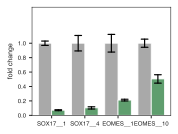

In [24]:
fig = plt.figure(figsize=(2.5, 2))

ax = sns.barplot(data=vals, x="info", y="value", hue="variable", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("fold change")
ax.get_legend().remove()
ax.set_ylim((0, 1.5))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# plot errors
xs = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]
c = 0
for i, x in enumerate(xs):
    if i % 2 == 0:
        name = order[c]
        c += 1
    subvals = vals[vals["info"] == name]
    subyerrs = yerrs[yerrs["info"] == name]
    if i % 2 == 0: #scrambled sgRNA
        val_ = subvals[subvals["type"] == "scramble"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "scramble"]["value"].iloc[0]
    else:
        val_ = subvals[subvals["type"] == "sgRNA"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "sgRNA"]["value"].iloc[0]
    ax.plot([x, x], [val_ - yerr_, val_ + yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ - yerr_, val_ - yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ + yerr_, val_ + yerr_], color="black")
    
fig.savefig("Fig4B.pdf", dpi="figure", bbox_inches="tight")

In [25]:
order = ["RP11-120D5.1__1", "RP11-120D5.1__2", "RP11-222K16.2__3", "RP11-222K16.2__9"]
pal = {"scrm_val": "darkgray", "sgrna_val": "dimgray"}

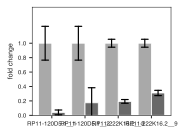

In [26]:
fig = plt.figure(figsize=(2.5, 2))

ax = sns.barplot(data=vals, x="info", y="value", hue="variable", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("fold change")
ax.get_legend().remove()
ax.set_ylim((0, 1.5))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# plot errors
xs = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]
c = 0
for i, x in enumerate(xs):
    if i % 2 == 0:
        name = order[c]
        c += 1
    subvals = vals[vals["info"] == name]
    subyerrs = yerrs[yerrs["info"] == name]
    if i % 2 == 0: #scrambled sgRNA
        val_ = subvals[subvals["type"] == "scramble"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "scramble"]["value"].iloc[0]
    else:
        val_ = subvals[subvals["type"] == "sgRNA"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "sgRNA"]["value"].iloc[0]
    ax.plot([x, x], [val_ - yerr_, val_ + yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ - yerr_, val_ - yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ + yerr_, val_ + yerr_], color="black")
    
fig.savefig("Fig4C.pdf", dpi="figure", bbox_inches="tight")

## 7. join all data, incl rt-qpcr

In [27]:
tmp1 = plot_df[plot_df["variable"].isin(["scrm_val", "scrm_yerr1", 
                                         "sgrna_val", "sgrna_yerr1"])][["info", "variable", "value"]]
tmp1 = tmp1.pivot(index="info", columns="variable").reset_index()
tmp1

info    value                                 
variable                   scrm_val scrm_yerr1 sgrna_val sgrna_yerr1
0                 EOMES__1      1.0   0.122592  0.211686    0.011610
1                EOMES__10      1.0   0.056404  0.504642    0.058451
2          RP11-120D5.1__1      1.0   0.234352  0.040950    0.033197
3          RP11-120D5.1__2      1.0   0.234352  0.173539    0.208916
4         RP11-222K16.2__3      1.0   0.054843  0.192999    0.026079
5         RP11-222K16.2__9      1.0   0.054843  0.309927    0.036625
6                 SOX17__1      1.0   0.030124  0.071298    0.006562
7                 SOX17__4      1.0   0.107328  0.103187    0.014963

In [28]:
genes = [x for x in val_data.gene_name.unique() if x not in ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2"]]
rem_plot_df = pd.DataFrame()

for key in qpcr_dict:
    gene = key.split("__")[0]
    if gene in genes:
        df = qpcr_dict[key]
        df["info"] = key
        rem_plot_df = rem_plot_df.append(df)
rem_plot_df.head()

gene     variable     value      type           info
0  ACVR2B-AS1     scrm_val  1.000000  scramble  ACVR2B-AS1__6
1  ACVR2B-AS1   scrm_yerr1  0.194374  scramble  ACVR2B-AS1__6
2  ACVR2B-AS1   scrm_yerr2  0.194374  scramble  ACVR2B-AS1__6
3  ACVR2B-AS1    sgrna_val  0.506980     sgRNA  ACVR2B-AS1__6
4  ACVR2B-AS1  sgrna_yerr1  0.100010     sgRNA  ACVR2B-AS1__6

In [29]:
tmp2 = rem_plot_df[rem_plot_df["variable"].isin(["scrm_val", "scrm_yerr1", 
                                                 "sgrna_val", "sgrna_yerr1"])][["info", "variable", "value"]]
tmp2 = tmp2.pivot(index="info", columns="variable").reset_index()
tmp2

info    value                                 
variable                  scrm_val scrm_yerr1 sgrna_val sgrna_yerr1
0           ACVR2B-AS1__6      1.0   0.194374  0.506980    0.100010
1           ACVR2B-AS1__8      1.0   0.194374  0.553504    0.213292
2                DIGIT__8      1.0   0.080243  0.100134    0.027577
3                FOXA2__1      1.0   0.034049  0.097621    0.006136
4                FOXA2__5      1.0   0.111688  0.073812    0.010502
5                GATA6__1      1.0   0.123753  0.539614    0.026357
6                GATA6__5      1.0   0.116883  0.373712    0.023067
7         KB-1440D3.14__9      1.0   0.298047  0.604298    0.083628
8            LINC00479__3      1.0   0.113193  0.547147    0.066948
9                 PVT1__1      1.0   0.179910  0.038296    0.007248
10                PVT1__2      1.0   0.099424  0.263036    0.097449
11                PVT1__6      1.0   0.110760  0.046284    0.006127
12                PVT1__9      1.0   0.110760  0.034039    0.004079
13        RP11-23F23.2__6      1.0   0.123599  0.110593    0.026408
14        RP3-508I15.9__1      1.0   0.121264  0.403321    0.046253
15        RP3-508I15.9__2      1.0   0.098210  0.422396    0.053275

In [30]:
qpcr_df = tmp1.append(tmp2)
qpcr_df["gene_name"] = qpcr_df["info"].str.split("__", expand=True)[0]
qpcr_df["guide_num"] = qpcr_df["info"].str.split("__", expand=True)[1].astype(int)

In [31]:
val_data = val_data.merge(qpcr_df, how="left", on=["gene_name", "guide_num"])
val_data.head()

gene_name  guide_num        guide_sequence  guide_undiff  scram_undiff  \
0  ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG         24.49          1.53   
1  ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG         38.75          1.53   
2       DIGIT          8  AAATCAGGCGGTGAGTACGT         23.99          1.82   
3       EOMES         10  CGCGGGCTAGTGGGTGGATG          9.68          1.65   
4       EOMES          1  TTTGCAAAGCATGCAGTTAG         39.81          1.65   

   guide_diff  scram_diff  rtqpcr_kd_level  date_facs  date_rtqpcr  ...  \
0       11.74       62.30             0.55     190906       190906  ...   
1        6.24       62.30             0.51     190906       190906  ...   
2       23.63       59.22             0.10     190816       190829  ...   
3       45.46       61.37             0.50     190508       190726  ...   
4       22.27       61.37             0.21     190508       190709  ...   

   transcript_biotype_status hit_status guide_undiff_enrich  \
0           promoter_overlap        hit            2.086031   
1           promoter_overlap        hit            6.209936   
2           promoter_overlap        hit            1.015235   
3             protein_coding        hit            0.212934   
4             protein_coding        hit            1.787607   

  scram_undiff_enrich  val_score       (info, )  (value, scrm_val)  \
0            0.024559   6.408389  ACVR2B-AS1__8                1.0   
1            0.024559   7.982207  ACVR2B-AS1__6                1.0   
2            0.030733   5.045888       DIGIT__8                1.0   
3            0.026886   2.985477      EOMES__10                1.0   
4            0.026886   6.055025       EOMES__1                1.0   

  (value, scrm_yerr1)  (value, sgrna_val)  (value, sgrna_yerr1)  
0            0.194374            0.553504              0.213292  
1            0.194374            0.506980              0.100010  
2            0.080243            0.100134              0.027577  
3            0.056404            0.504642              0.058451  
4            0.122592            0.211686              0.011610  

[5 rows x 22 columns]

## 5. write updated file

In [32]:
val_data.columns

Index([                'gene_name',                 'guide_num',
                  'guide_sequence',              'guide_undiff',
                    'scram_undiff',                'guide_diff',
                      'scram_diff',           'rtqpcr_kd_level',
                       'date_facs',               'date_rtqpcr',
                      'sgRNA_l2fc',                    'tss_id',
       'transcript_biotype_status',                'hit_status',
             'guide_undiff_enrich',       'scram_undiff_enrich',
                       'val_score',                ('info', ''),
             ('value', 'scrm_val'),     ('value', 'scrm_yerr1'),
            ('value', 'sgrna_val'),    ('value', 'sgrna_yerr1')],
      dtype='object')

In [33]:
val_data = val_data.iloc[:, [0, 1, 2, 8, 9, 3, 4, 5, 6, 10, 16, 13, 20, 21, 18, 19]]
val_data.columns = ["gene_name", "sgRNA_num", "sgRNA", "FACS_date", "RTqPCR_date", "sgRNA_FACS_pUndiff",
                    "scrambled_FACS_pUndiff", "sgRNA_FACS_pDiff", "scrambled_FACS_pDiff", "sgRNA_screen_l2fc",
                    "sgRNA_validation_score", "screen_hit_status", "sgRNA_RTqPCR_mean", "sgRNA_RTqPCR_error",
                    "scrambled_RTqPCR_mean", "scrambled_RTqPCR_error"]
val_data.head()

gene_name  sgRNA_num                 sgRNA  FACS_date  RTqPCR_date  \
0  ACVR2B-AS1          8  TAGAGGCGCCCCTGCGATGG     190906       190906   
1  ACVR2B-AS1          6  TAGCCCGAACTCCGACCCTG     190906       190906   
2       DIGIT          8  AAATCAGGCGGTGAGTACGT     190816       190829   
3       EOMES         10  CGCGGGCTAGTGGGTGGATG     190508       190726   
4       EOMES          1  TTTGCAAAGCATGCAGTTAG     190508       190709   

   sgRNA_FACS_pUndiff  scrambled_FACS_pUndiff  sgRNA_FACS_pDiff  \
0               24.49                    1.53             11.74   
1               38.75                    1.53              6.24   
2               23.99                    1.82             23.63   
3                9.68                    1.65             45.46   
4               39.81                    1.65             22.27   

   scrambled_FACS_pDiff  sgRNA_screen_l2fc  sgRNA_validation_score  \
0                 62.30           2.358497                6.408389   
1                 62.30           3.129730                7.982207   
2                 59.22           2.676944                5.045888   
3                 61.37           5.932002                2.985477   
4                 61.37           7.778685                6.055025   

  screen_hit_status  sgRNA_RTqPCR_mean  sgRNA_RTqPCR_error  \
0               hit           0.553504            0.213292   
1               hit           0.506980            0.100010   
2               hit           0.100134            0.027577   
3               hit           0.504642            0.058451   
4               hit           0.211686            0.011610   

   scrambled_RTqPCR_mean  scrambled_RTqPCR_error  
0                    1.0                0.194374  
1                    1.0                0.194374  
2                    1.0                0.080243  
3                    1.0                0.056404  
4                    1.0                0.122592

In [34]:
# update sgRNA numbers so they reflect what's in the corr plot
gene_order = ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2", "FOXA2", "GATA6", 'ACVR2B-AS1', 'DIGIT', 
              'KB-1440D3.14', 'LINC00479', 'PVT1', 'RP11-23F23.2', 'RP3-508I15.9']
gene_order_df = pd.DataFrame(gene_order).reset_index()
gene_order_df.columns = ["rank", "gene_name"]
gene_order_df

rank      gene_name
0      0          SOX17
1      1          EOMES
2      2   RP11-120D5.1
3      3  RP11-222K16.2
4      4          FOXA2
5      5          GATA6
6      6     ACVR2B-AS1
7      7          DIGIT
8      8   KB-1440D3.14
9      9      LINC00479
10    10           PVT1
11    11   RP11-23F23.2
12    12   RP3-508I15.9

In [35]:
val_data = val_data.merge(gene_order_df, on="gene_name")
val_data = val_data.sort_values(by=["rank", "sgRNA_num"], ascending=True)

In [36]:
val_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
val_data["sgRNA_num"] = val_data["level_0"] + 1
val_data.drop(["level_0", "index", "rank"], axis=1, inplace=True)
val_data

gene_name  sgRNA_num                 sgRNA  FACS_date  RTqPCR_date  \
0           SOX17          1  TCTGGTCTACAGCGTACCCA     190325       190326   
1           SOX17          2  GCTGTAGACCAGACCGCGAC     190508       190709   
2           EOMES          3  TTTGCAAAGCATGCAGTTAG     190508       190709   
3           EOMES          4  CGCGGGCTAGTGGGTGGATG     190508       190726   
4    RP11-120D5.1          5  GGGAAGGTTGTCTGCTCCAG     190906       190906   
5    RP11-120D5.1          6  ATAGTAGAGCTCTTCACTCT     190906       190906   
6   RP11-222K16.2          7  TGTCTTGAAAAGAATGTCGG     190325       190326   
7   RP11-222K16.2          8  GAGCTGTCGAAATCTCCGCG     190325       190326   
8           FOXA2          9  CAGGCCAGCGCCCCGCGGTA     190508       190709   
9           GATA6         10  ACCCACAGCCTGGCACCCTT     190508       190709   
10     ACVR2B-AS1         11  TAGCCCGAACTCCGACCCTG     190906       190906   
11     ACVR2B-AS1         12  TAGAGGCGCCCCTGCGATGG     190906       190906   
12          DIGIT         13  AAATCAGGCGGTGAGTACGT     190816       190829   
13   KB-1440D3.14         14  CCTCAAACTACCCCTCCCCC     190822       190829   
14      LINC00479         15  TTTACGGCACCTTGGTGCGA     190822       190829   
15           PVT1         16  GTCGTCGCCCCTCCTCGTCC     190822       190906   
16           PVT1         17  CGGCCGAGCACATGGGCCCG     190816       190829   
17           PVT1         18  TCAATCCTCAGAACCCTGAG     190822       190829   
18           PVT1         19  CCCGAGCCCGCCCGGCCCGC     190822       190829   
19   RP11-23F23.2         20  CTCGGTTCAATGAGGGCCCC     190822       190829   
20   RP3-508I15.9         21  GAAGCCCCGACGCCCGGATA     190822       190829   
21   RP3-508I15.9         22  CCGACGCCCGGATAAGGCCA     190903       190906   

    sgRNA_FACS_pUndiff  scrambled_FACS_pUndiff  sgRNA_FACS_pDiff  \
0                81.23                    1.48              0.06   
1                82.26                    1.65              8.55   
2                39.81                    1.65             22.27   
3                 9.68                    1.65             45.46   
4                49.19                    1.53              3.88   
5                26.54                    1.53              3.90   
6                 1.49                    1.48             38.45   
7                 1.27                    1.48             24.01   
8                 3.41                    1.65              8.41   
9                50.85                    1.65             19.22   
10               38.75                    1.53              6.24   
11               24.49                    1.53             11.74   
12               23.99                    1.82             23.63   
13               33.19                    1.29             12.59   
14                1.62                    1.29             67.17   
15                2.51                    1.29             53.02   
16                5.89                    1.82             33.69   
17                1.12                    1.29             56.43   
18                6.00                    1.29             36.63   
19                1.78                    1.29             45.74   
20                2.04                    1.29             46.33   
21                5.11                    1.54             59.74   

    scrambled_FACS_pDiff  sgRNA_screen_l2fc  sgRNA_validation_score  \
0                  60.59           2.652514               15.758245   
1                  61.37           7.864574                8.483190   
2                  61.37           7.778685                6.055025   
3                  61.37           5.932002                2.985477   
4                  62.30           4.046443                9.011865   
5                  62.30           4.156723                8.114251   
6                  60.59          -0.170594                0.665811   
7                  60.59           3.303674                1.114676   
8        

In [37]:
val_data.to_csv("../../../data/02__screen/03__validation_data/SuppTable_S4.validation_results.txt", sep="\t",
               index=False)